In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydotplus # viz stuff

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree # export_graphviz() method

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,  cross_val_score

from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

from IPython.display import Image # viz stuff

In [2]:
df = pd.read_csv("data/data_understanding_output.csv", skipinitialspace=True)
df_train = df.drop(['word','PoS', 'length', 'number_of_meanings', 'avg_variance_between_meanings', 'polysemy'], axis=1)

In [3]:
df_train.head()

,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,log_freq,sentiment
0,4.200,2.864,4.333,5.455,4.391,2.382,6.760,4.652,5.391,5.204321,1.0
1,3.125,5.781,4.667,5.906,5.344,3.324,5.177,5.121,3.303,6.625813,1.0
2,3.273,5.250,5.235,3.286,3.177,5.121,5.543,2.667,3.971,5.146454,1.0
3,4.194,3.767,4.419,3.367,2.516,3.971,6.233,4.679,5.167,5.093852,1.0
4,3.846,3.880,4.800,3.292,2.571,3.097,6.407,5.083,4.571,5.107695,1.0


# Tree Classifier
### With hyper paramether tuning with Grid Search CV

In [4]:
attributes = [col for col in df_train.columns if col != 'sentiment']
X = df_train[attributes].values
y = df_train['sentiment']

In [5]:
# Questo blocco ci mette un botto ad eseguire e serve solo a trovare i parametri migliori

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

twotwenty = list(range(2,20))
    
param_list = {'max_depth': [None] + twotwenty,
             'min_samples_split': twotwenty,
             'min_samples_leaf': list(range(1,20))
             }

grid_search = GridSearchCV(clf, param_grid=param_list, scoring='f1_weighted')
grid_search.fit(X, y)

res = grid_search.cv_results_

report(res, n_top=10)

NameError: name 'clf' is not defined

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [57]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=7 ,
                             min_samples_split=11,
                             min_samples_leaf=15,
                            )

clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=7, min_samples_leaf=15, min_samples_split=11)

In [8]:
imp_dict = {attr: clf.feature_importances_[i] for i, attr in enumerate(attributes)}
{k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)}

{'valence': 0.6354963634019792,
 'concreteness': 0.14961307157941903,
 'familiarity': 0.06811086668751587,
 'arousal': 0.04962708952306563,
 'dominance': 0.025003649161725133,
 'imageability': 0.023501120012401452,
 'semsize': 0.020401868936008257,
 'log_freq': 0.01571141441222225,
 'aoa': 0.01237364307966365,
 'gender': 0.00016091320599964477}

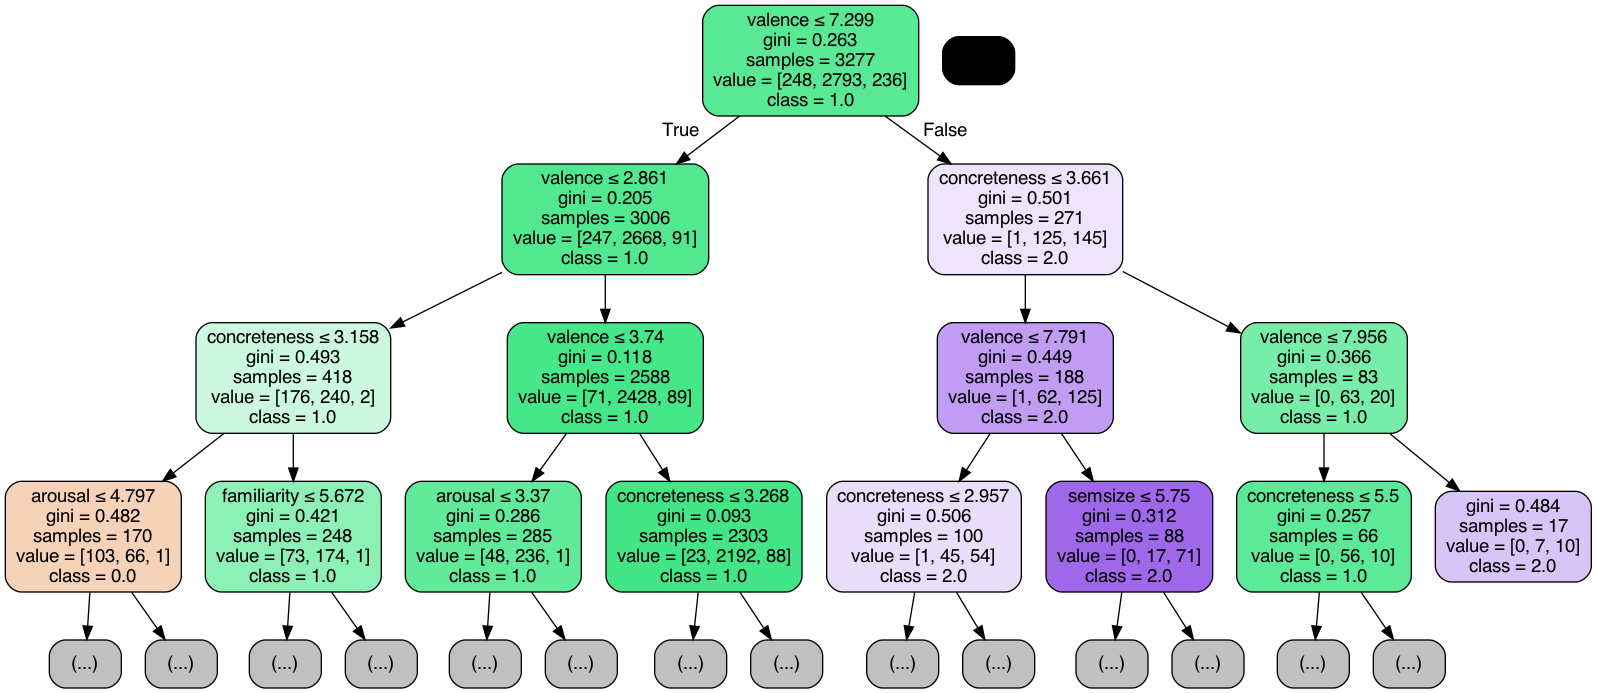

In [9]:
dot_data = tree.export_graphviz (clf, out_file=None,
                                feature_names=attributes,
                                class_names=[str(v) for v in clf.classes_],
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [51]:
y_pred = clf.predict(X_train)

In [52]:
print( classification_report(y_train, y_pred) )

              precision    recall  f1-score   support

         0.0       0.74      0.59      0.65       248
         1.0       0.93      0.97      0.95      2793
         2.0       0.75      0.57      0.65       236

    accuracy                           0.91      3277
   macro avg       0.81      0.71      0.75      3277
weighted avg       0.90      0.91      0.90      3277



In [53]:
y_pred = clf.predict(X_test)

In [13]:
print( classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

         0.0       0.58      0.49      0.53       106
         1.0       0.92      0.94      0.93      1198
         2.0       0.66      0.58      0.62       101

    accuracy                           0.88      1405
   macro avg       0.72      0.67      0.69      1405
weighted avg       0.88      0.88      0.88      1405



In [14]:
df_train['sentiment'].value_counts()

1.0    3991
0.0     354
2.0     337
Name: sentiment, dtype: int64

# Random Over Sampling

In [15]:
ros = RandomOverSampler(random_state=1, sampling_strategy='not majority')

In [16]:
X_ros, y_ros = ros.fit_resample(X, y)

In [17]:
Counter(y), Counter(y_ros)

(Counter({1.0: 3991, 2.0: 337, 0.0: 354}),
 Counter({1.0: 3991, 2.0: 3991, 0.0: 3991}))

In [18]:
X_ros_train, X_ros_test, y_ros_train, y_ros_test=train_test_split(X_ros, y_ros, test_size=0.3, stratify=y_ros, random_state=1)

In [19]:
ros_clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=None ,
                             min_samples_split=7,
                             min_samples_leaf=1,
                            )


ros_clf.fit(X_ros_train, y_ros_train)

DecisionTreeClassifier(min_samples_split=7)

In [58]:
twotwenty = list(range(2,20))
    
param_list = {'max_depth': [None] + twotwenty,
             'min_samples_split': twotwenty,
             'min_samples_leaf': list(range(1,20))
             }

ros_grid_search = GridSearchCV(ros_clf, param_grid=param_list, scoring='f1_weighted')
ros_grid_search.fit(X_ros, y_ros)

KeyboardInterrupt: 

In [ ]:
ros_res = ros_grid_search.cv_results_

report(ros_res, n_top=10)

In [ ]:
imp_dict = {attr: ros_clf.feature_importances_[i] for i, attr in enumerate(attributes)}
{k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
dot_data = tree.export_graphviz (ros_clf, out_file=None,
                                feature_names=attributes,
                                class_names=[str(v) for v in ros_clf.classes_],
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
y_ros_pred = ros_clf.predict(X_ros_train)
print( classification_report(y_ros_train, y_ros_pred) )

In [ ]:
y_ros_pred = ros_clf.predict(X_ros_test)
print( classification_report(y_ros_test, y_ros_pred) )

In [ ]:
y_ros_score = ros_clf.predict_proba(X_ros_test)
roc_auc_score(y_ros_test, y_ros_score, multi_class='ovr', average='weighted')

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}


n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_ros_test, y_ros_score[:,i], pos_label=i)
    
plt.figure(figsize=(8,5))

plt.plot(fpr[0], tpr[0], label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], label='Class 2 vs Rest')
plt.plot([0,1], [0,1], 'k--')
plt.legend(loc='best')


plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

# K-Neighbor Classifier

In [33]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_ros_train, y_ros_train)

scores = cross_val_score(knn, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(knn, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.8721 (+/- 0.04)
F1-score: 0.6640 (+/- 0.08)


In [23]:
y_ros_pred = knn.predict(X_ros_train)
print( classification_report(y_ros_train, y_ros_pred) )

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2794
         1.0       1.00      0.85      0.92      2793
         2.0       0.95      1.00      0.97      2794

    accuracy                           0.95      8381
   macro avg       0.95      0.95      0.95      8381
weighted avg       0.95      0.95      0.95      8381



In [24]:
y_ros_pred = knn.predict(X_ros_test)
print( classification_report(y_ros_test, y_ros_pred) )

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      1197
         1.0       1.00      0.78      0.88      1198
         2.0       0.91      1.00      0.95      1197

    accuracy                           0.93      3592
   macro avg       0.93      0.93      0.92      3592
weighted avg       0.93      0.93      0.92      3592



In [25]:
y_ros_score = knn.predict_proba(X_ros_test)
roc_auc_score(y_ros_test, y_ros_score, multi_class='ovr', average='weighted')

0.973274463962741

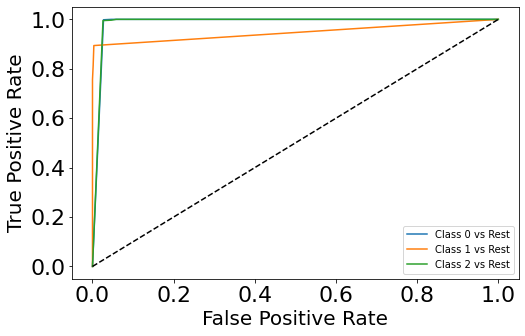

In [26]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}


n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_ros_test, y_ros_score[:,i], pos_label=i)
    
plt.figure(figsize=(8,5))

plt.plot(fpr[0], tpr[0], label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], label='Class 2 vs Rest')
plt.plot([0,1], [0,1], 'k--')
plt.legend(loc='best')


plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

# Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rfc = RandomForestClassifier(n_estimators=1000, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             class_weight=None)


scores = cross_val_score(rfc, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(rfc, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.8891 (+/- 0.02)
F1-score: 0.6713 (+/- 0.08)


In [37]:
rfc.fit(X_ros_train, y_ros_train)

RandomForestClassifier(n_estimators=1000)

In [38]:
y_ros_pred = rfc.predict(X_ros_train)
print( classification_report(y_ros_train, y_ros_pred) )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2794
         1.0       1.00      1.00      1.00      2793
         2.0       1.00      1.00      1.00      2794

    accuracy                           1.00      8381
   macro avg       1.00      1.00      1.00      8381
weighted avg       1.00      1.00      1.00      8381



In [39]:
y_ros_pred = rfc.predict(X_ros_test)
print( classification_report(y_ros_test, y_ros_pred) )

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1197
         1.0       1.00      0.92      0.96      1198
         2.0       0.97      1.00      0.98      1197

    accuracy                           0.97      3592
   macro avg       0.97      0.97      0.97      3592
weighted avg       0.97      0.97      0.97      3592



In [40]:
y_ros_score = rfc.predict_proba(X_ros_test)
roc_auc_score(y_ros_test, y_ros_score, multi_class='ovr', average='weighted')

0.9999937794968503

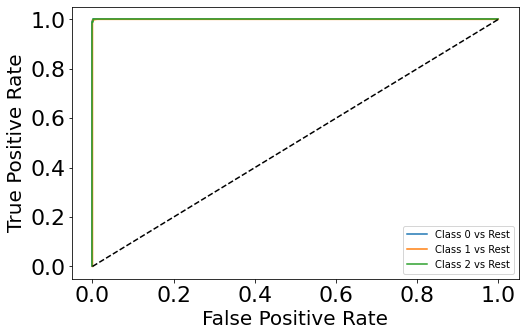

In [41]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}


n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_ros_test, y_ros_score[:,i], pos_label=i)
    
plt.figure(figsize=(8,5))

plt.plot(fpr[0], tpr[0], label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], label='Class 2 vs Rest')
plt.plot([0,1], [0,1], 'k--')
plt.legend(loc='best')


plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [ ]:
rfcscore = cross_val_score(rfc, X, y, cv=10)
knnscore = cross_val_score(knn, X, y, cv=10)
clfscore = cross_val_score(clf, X, y, cv=10)
results = {}
results['Random Forest Classifier'] = rfcscore.mean()

results['Knn Classifier'] = knnscore.mean()

results['Decision Tree Classifier'] = clfscore.mean()

plt.bar(range(len(results)), results.values(), align='center')
plt.xticks(range(len(results)), list(results.keys()), rotation='vertical')
plt.show()